# Setup

In [1]:
# import IPython
# import IPython.display
# import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
# import tensorflow as tf
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
# from warnings import catch_warnings, filterwarnings
from tqdm.notebook import tqdm
# import itertools
# import statsmodels.api as sm
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima
import datetime as dt
# mpl.rcParams['figure.figsize'] = (16, 8)

In [2]:
# gpu_devices = tf.config.experimental.list_physical_devices("GPU")
# for device in gpu_devices:
#     tf.config.experimental.set_memory_growth(device, True)

## Display

In [3]:
# Facebook Prophet gives a number of info/warning messages which can't be suppressed using standard context manager 
# techniques. This code allows hiding cells which contain stderr output, which includes the Prophet messages.

# From answer given by user matthiash on StackOverflow at https://stackoverflow.com/a/43118091 
# Full discussion: https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [4]:
nonimputed_train_file_name = 'Data/nonimputed.pkl'
nonimputed_df = pd.read_pickle(nonimputed_train_file_name)
imputed_file_name = 'Data/imputed.pkl'
imputed_df = pd.read_pickle(imputed_file_name)

In [5]:
pd.set_option('display.max_columns', None)
nonimputed_df

station_id,26,27,28,29,31,32,33,34,35,38,39,40,41,42,43,44,45,46,51,103,110,164,175,179,187,191,198,199,200,204,208,209,210,211,212,214,218,219,220,221,222,223,225,227,228,229,230,231,232,233,301,303,305,309,315,321,326,329,335,336,341,342,351,352,353,354,365,381,382,384,386,388,389,390,400,402,405,407,410,420,425,458,460,464
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-01-31,NaN,NaN,0.052486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001496,0.222437,0.121403,0.038712,0.087059,0.009524,0.079728,0.193349,0.010686,0.006802,0.166906,0.044060,0.132612,0.002758,0.005171,0.014170,0.101161,0.001825,0.003310,0.015084,0.007285,0.012281,0.006085,0.016705,0.012061,0.038678,NaN,NaN,NaN,NaN,NaN,NaN,0.868951,0.715468,0.466652,0.470439,0.539561,0.823631,0.744542,0.497646,0.185128,0.383304,0.323502,NaN,0.067856,0.161180,0.093716,0.359543,0.176347,0.038977,0.114261,0.137578,0.031812,0.093287,0.234939,0.049637,0.006802,0.125377,0.499697,0.099152,0.013519,0.157384,0.122028,0.031680,0.034492,0.116397
2002-02-28,NaN,NaN,0.048293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001308,0.207839,0.112253,0.037746,0.081295,0.008500,0.075292,0.181825,0.009781,0.005866,0.158088,0.040140,0.124818,0.002417,0.005075,0.013894,0.093021,0.001714,0.003138,0.015112,0.007017,0.011879,0.005488,0.016706,0.011353,0.037158,NaN,NaN,NaN,NaN,NaN,NaN,0.812379,0.660391,0.428383,0.427034,0.496669,0.765851,0.680767,0.468366,0.171533,0.351505,0.298361,NaN,0.061063,0.149731,0.088018,0.340470,0.165602,0.036146,0.106966,0.126254,0.028478,0.083734,0.214891,0.045749,0.006432,0.112651,0.455085,0.090210,0.012430,0.146251,0.111372,0.029863,0.031562,0.104315
2002-03-31,NaN,NaN,0.051945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001535,0.225097,0.133037,0.040850,0.096186,0.009501,0.084988,0.201587,0.010744,0.006376,0.179050,0.040014,0.148466,0.003024,0.005279,0.014561,0.100424,0.001702,0.003278,0.016579,0.007499,0.012984,0.006072,0.017556,0.012309,0.044179,NaN,NaN,NaN,NaN,NaN,NaN,0.880137,0.722726,0.476633,0.509003,0.546668,0.842599,0.734901,0.505107,0.188526,0.381739,0.321143,NaN,0.067736,0.162873,0.099576,0.379765,0.175184,0.040655,0.121986,0.135840,0.030284,0.091642,0.224449,0.050076,0.006961,0.123702,0.494695,0.094906,0.013402,0.162369,0.120730,0.030988,0.034328,0.115487
2002-04-30,NaN,NaN,0.051007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001781,0.230523,0.129694,0.041973,0.097801,0.010570,0.090395,0.201193,0.011841,0.007384,0.192373,0.043364,0.149851,0.003110,0.005282,0.014855,0.106382,0.001674,0.003769,0.015686,0.008018,0.013617,0.006928,0.018405,0.013574,0.045707,NaN,NaN,NaN,NaN,NaN,NaN,0.897782,0.741273,0.498265,0.510820,0.570199,0.849604,0.757622,0.522922,0.195504,0.396857,0.343076,NaN,0.070892,0.177520,0.103582,0.386652,0.184323,0.043825,0.126761,0.146649,0.032767,0.097751,0.237828,0.055039,0.007822,0.126040,0.513146,0.102990,0.014929,0.166675,0.127502,0.035397,0.036101,0.121156
2002-05-31,NaN,NaN,0.047346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003348,0.248476,0.141523,0.053489,0.120171,0.013918,0.117939,0.238743,0.013376,0.008952,0.224656,0.068221,0.164345,0.003543,0.006375,0.022270,0.113209,0.002701,0.005293,0.021311,0.011726,0.017855,0.012644,0.026273,0.017146,0.053204,NaN,NaN,NaN,NaN,NaN,NaN,0.924678,0.787257,0.526708,0.525958,0.599008,0.869573,0.790910,0.538820,0.214965,0.425145,0.366252,NaN,0.081826,0.203224,0.116654,0.433182,0.216401,0.053024,0.145502,0.164300,0.040584,0.109064,0.237568,0.063171,0.010305,0.138938,0.551639,0.124315,0.017397,0.176947,0.139346,0.039318,0.040644,0.124577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020

In [6]:
imputed_df

station_id,26,27,28,29,31,32,33,34,35,38,39,40,41,42,43,44,45,46,51,103,110,164,175,179,187,191,198,199,200,204,208,209,210,211,212,214,218,219,220,221,222,223,225,227,228,229,230,231,232,233,301,303,305,309,315,321,326,329,335,336,341,342,351,352,353,354,365,381,382,384,386,388,389,390,400,402,405,407,410,420,425,458,460,464
2002-01-31,0.084979,0.024494,0.052486,0.033584,0.024094,0.129039,0.023635,0.013464,0.025457,0.144042,0.047908,0.261581,0.001678,0.143937,0.070532,0.003470,0.058665,0.001658,0.001496,0.222437,0.121403,0.038712,0.087059,0.009524,0.079728,0.193349,0.010686,0.006802,0.166906,0.044060,0.132612,0.002758,0.005171,0.014170,0.101161,0.001825,0.003310,0.015084,0.007285,0.012281,0.006085,0.016705,0.012061,0.038678,0.002660,0.004577,0.010482,0.001093,0.001099,0.005267,0.868951,0.715468,0.466652,0.470439,0.539561,0.823631,0.744542,0.497646,0.185128,0.383304,0.323502,0.544846,0.067856,0.161180,0.093716,0.359543,0.176347,0.038977,0.114261,0.137578,0.031812,0.093287,0.234939,0.049637,0.006802,0.125377,0.499697,0.099152,0.013519,0.157384,0.122028,0.031680,0.034492,0.116397
2002-02-28,0.079550,0.023708,0.048293,0.032956,0.023515,0.123104,0.022246,0.013223,0.024746,0.141029,0.046472,0.252585,0.001521,0.137251,0.067610,0.003295,0.053573,0.001711,0.001308,0.207839,0.112253,0.037746,0.081295,0.008500,0.075292,0.181825,0.009781,0.005866,0.158088,0.040140,0.124818,0.002417,0.005075,0.013894,0.093021,0.001714,0.003138,0.015112,0.007017,0.011879,0.005488,0.016706,0.011353,0.037158,0.002459,0.004356,0.009582,0.001043,0.001090,0.005086,0.812379,0.660391,0.428383,0.427034,0.496669,0.765851,0.680767,0.468366,0.171533,0.351505,0.298361,0.519209,0.061063,0.149731,0.088018,0.340470,0.165602,0.036146,0.106966,0.126254,0.028478,0.083734,0.214891,0.045749,0.006432,0.112651,0.455085,0.090210,0.012430,0.146251,0.111372,0.029863,0.031562,0.104315
2002-03-31,0.103057,0.029333,0.051945,0.036387,0.026754,0.146406,0.025984,0.015610,0.027670,0.157588,0.053672,0.290083,0.001737,0.158015,0.077412,0.003728,0.060866,0.001926,0.001535,0.225097,0.133037,0.040850,0.096186,0.009501,0.084988,0.201587,0.010744,0.006376,0.179050,0.040014,0.148466,0.003024,0.005279,0.014561,0.100424,0.001702,0.003278,0.016579,0.007499,0.012984,0.006072,0.017556,0.012309,0.044179,0.002780,0.005091,0.011433,0.001256,0.001311,0.006064,0.880137,0.722726,0.476633,0.509003,0.546668,0.842599,0.734901,0.505107,0.188526,0.381739,0.321143,0.599891,0.067736,0.162873,0.099576,0.379765,0.175184,0.040655,0.121986,0.135840,0.030284,0.091642,0.224449,0.050076,0.006961,0.123702,0.494695,0.094906,0.013402,0.162369,0.120730,0.030988,0.034328,0.115487
2002-04-30,0.102181,0.029270,0.051007,0.035781,0.028017,0.148669,0.025848,0.016378,0.027597,0.161930,0.056398,0.291423,0.002082,0.165340,0.082172,0.004345,0.063712,0.002136,0.001781,0.230523,0.129694,0.041973,0.097801,0.010570,0.090395,0.201193,0.011841,0.007384,0.192373,0.043364,0.149851,0.003110,0.005282,0.014855,0.106382,0.001674,0.003769,0.015686,0.008018,0.013617,0.006928,0.018405,0.013574,0.045707,0.002828,0.005467,0.012322,0.001456,0.001721,0.006451,0.897782,0.741273,0.498265,0.510820,0.570199,0.849604,0.757622,0.522922,0.195504,0.396857,0.343076,0.603790,0.070892,0.177520,0.103582,0.386652,0.184323,0.043825,0.126761,0.146649,0.032767,0.097751,0.237828,0.055039,0.007822,0.126040,0.513146,0.102990,0.014929,0.166675,0.127502,0.035397,0.036101,0.121156
2002-05-31,0.113216,0.022125,0.047346,0.044722,0.030978,0.159405,0.027594,0.018580,0.031516,0.167321,0.061217,0.294899,0.002365,0.178457,0.097716,0.005655,0.068676,0.002325,0.003348,0.248476,0.141523,0.053489,0.120171,0.013918,0.117939,0.238743,0.013376,0.008952,0.224656,0.068221,0.164345,0.003543,0.006375,0.022270,0.113209,0.002701,0.005293,0.021311,0.011726,0.017855,0.012644,0.026273,0.017146,0.053204,0.004266,0.006282,0.013146,0.001882,0.002138,0.007328,0.924678,0.787257,0.526708,0.525958,0.599008,0.869573,0.790910,0.538820,0.214965,0.425145,0.366252,0.635607,0.081826,0.203224,0.116654,0.433182

# Models

Initially, we create a base class for models. This will maintain the ability to validate, fit, predict, plot, and score models. Individuals models will be subclassed from the base class. Subclasses will not necessarily implement all methods - for example, the baseline models will not implement validation or the ability to calculate margins of error.

In [7]:
class index_range:
    def __init__(self, idx, splits=[0.7, 0.8]):
        '''
        Constructor for index_range class
        
        Inputs:
        idx, a Pandas datetime index.
        splits, optional listlike object. The index idx is split into three indices where the first two entries of splits 
            indicate the proportions of the original index to be included in each split. The list must be in increasing
            order and have values between 0 and 1.
            
        Raises:
            ValueError if splits is invalid.
        '''      
        # Catch invalid conditions for splits.
        if splits[0] < 0:
            raise ValueError(f"The entry splits[0] = {splits[0]} cannot be negative.")
        if splits[1] < splits[0]:
            raise ValueError(f"The entry splits must be non-decreasing. Received splits[1] = {splits[1]} >" 
                               + f" {splits[0]} = splits[0]")
        if splits[1] > 1:
            raise ValueError(f"The entry splits[1] = {splits[1]} cannot be greater than 1.")
        
        n = len(idx)
        a = int(n * splits[0])
        b = int(n * splits[1])
        
        self._full_idx = idx
        self._train_idx = idx[:b]
        self._val_train_idx = idx[:a]
        
        if a < b:
            self._val_idx = idx[a:b]
        else:
            self._val_idx = None
            
        self._test_idx = idx[b:]        
        
    def _print_split(self, idx):
        ends = self._idx_repr(idx)
        return f'{ends[0]} / {ends[1]}, {len(idx)} rows'
        
    def __repr__(self):
        if self._val_idx is not None:
            return '\n'.join([
                f'Split 1: {self._print_split(self._val_train_idx)}',
                f'Split 2: {self._print_split(self._val_idx)}',
                f'Split 3: {self._print_split(self._test_idx)}',
                f'Total Rows: {len(self._full_idx)}'
            ])
        else:
            return '\n'.join([
                f'Split 1: {self._print_split(self._val_train_idx)}',
                f'Split 2: {self._print_split(self._test_idx)}',
                f'Total Rows: {len(self._full_idx)}'
            ])            

    def _idx_repr(self, idx):
        return idx[0].date(), idx[-1].date()

    def endpoints(self, index_range):
        '''
        Returns the endpoints of the requested frame index.
        
        index_range is a string. It must be one of 'train', 'test', 'validation', 'full', or 'validation_train'.
        '''
        # Get date range corresponding to index_range
        if index_range == 'train':
            return self._idx_repr(self._train_idx)
        elif index_range == 'test':
            return self._idx_repr(self._test_idx)
        elif index_range == 'validation':
            return self._idx_repr(self._val_idx)
        elif index_range == 'full':
            return self._idx_repr(self._full_idx)
        elif index_range == 'validation_train':
            return self._idx_repr(self._val_train_idx)
        elif isinstance(index_range, str):
            # Invalid argument, string outside of acceptable values.
            raise ValueError(f'Invalid parameter prediction_range. Expected one of \'train\', \'test\', \'validation\',' \
                             + f'\'full\', \'validation_train\', or \'auto\', received {index_range}.')
        else:
            # Invalid parameter, wrong type.
            raise TypeError(f'Invalid parameter prediction_range. Expected string, received {type(index_range)}.')

In [8]:
class model_data:
    '''
    Contains data for model class.
    '''
    def __init__(self, df, splits=[0.7, 0.8]):
        '''
        Constructor for model_data class
        
        Inputs:
        df, a Pandas data frame.
        splits, optional listlike object. The frame df is split into three frames where the first two entries of splits 
            indicate the proportions of the original frame to be included in each split. The list must be in increasing
            order and have values between 0 and 1.
            
        Raises:
            ValueError if splits is invalid.
        '''
        # Pushes validation of splits down to index_range, which has the same requirements.
        try:
            self._index = index_range(df.index, splits)
        except:
            raise

        n = len(df)
        a = int(n * splits[0])
        b = int(n * splits[1])
        
        self._full_df = df
        self._train_df = df[:b]
        self._val_train_df = df[:a]
        
        if a < b:
            self._val_df = df[a:b]
        else:
            # Only other case is a==b
            self._val_df = None
            
        self._test_df = df[b:]
        
    def __repr__(self):
        return '\n'.join([
            f'Columns: {self.columns}, Count: {len(self.columns)}',
            f'{self.index}'
        ])
        
    @property
    def full(self):
        return self._full_df
    
    @property
    def train(self):
        return self._train_df

    @property
    def validation_train(self):
        return self._val_train_df
    
    @property
    def validation(self):
        return self._val_df

    @property
    def test(self):
        return self._test_df
    
    @property
    def index(self):
        return self._index
    
    @property
    def columns(self):
        return self._full_df.columns

In [9]:
class model:
    '''
    Interface for a time series prediction model.        
    '''
    
    def __init__(self, data, name=None):
        self._data = model_data(data)
        if name is None:
            self._name = self.__class__.__name__
        else:
            self._name = name
        
        # Members used in model fitting
        self._model = None
        self._fit_range = None
        self._val_fit_range = None
        # Parameters should be empty dicts instead of None as they will be compared to (possibly empty) **kwargs
        self._model_params = {} # Keyword parameters passed in fitting model.
        self._val_params = {} # Keyword parameters passed in fitting model via validation.
        self._val_best_params = {} # Keyword parameters returned in validation.
        
        # Members used in predictions
        self._predictions = {}
        
    @property
    def name(self):
        return self._name
    
    @property
    def model_parameters(self):
        return self._model_parameters
    
    # Pure virtual methods for model fitting
    
    # Must be implented
    def _fit_implementation(self, fit_range, **kwargs):
        # Individual model fit implementation
        raise NotImplementedError
    @staticmethod
    def _implements_validation():
        # Should return True if the model implements validation, False otherwise.
        raise NotImplementedError
    # Only needs to be implemented if _implements_validation returns True.
    def _validation_implementation(self, fit_range, validation_range, **kwargs):
        # Individual model validation implementation
        raise NotImplementedError

    # Pure virtual methods for prediction
    
    # Must be implemented
    def _predict_implementation(self, date_index, margin_of_error=False):
        # Individual model prediction algorithm
        raise NotImplementedError
    @staticmethod
    def _implements_margin_of_error():
        # Should return True if the model implements margin of error, False otherwise.
        raise NotImplementedError

In [10]:
#
# MODEL FITTING
#

def fit(self, fit_range='auto', validation=False, fit_validation=True, force_refit=False, **kwargs):
    '''
    Fits the model to the training set. If a model has previously been fit, replaces the older model.

    Inputs:
        fit_range is an optional string. This is the dataframe to train the model on. Must be one of 'validation_train', 
            'train', 'full', or 'auto'. Default is 'auto', which is the same as 'train'.
        validation is an optional boolean. If True, will validate the model training on the next split of the dataframe.
            If fit_range is 'validation_train', this will be 'validation'. If fit_range is 'train', this will be 'test'.
            If fit_range is 'full', validation will not be performed. Defaults to False. Specific subclasses may not
            implement validation. Ignored if this is the case.
        fit_validation is an optional boolean. If True and validation is True, will refit the model using the best 
            parameters found in the validation. This will fit on the combined training and validation frames used in the
            validation. Defaults to True, but has no effect unless validation is True.
        force_refit is an optional boolean. If True, will fit the model even if it has already been trained on this set.
            Defaults to False. If validation is True, is always False unless fit_validation is also True.
            
        **kwargs are specific model parameters or a parameter grid, passed to the fitting or validation implementation. If
            validation is True, will be passed to the validation implementation, otherwise will be passed to the fitting 
            implementation. Beware that if fit_range is 'full', this can lead to unexpected consquences.
        
    Returns:
        None.
    '''
    # fit_range is allowed to be 'auto'. Update that to the default.
    if fit_range == 'auto':
        fit_range = 'train'
        
    # Check if conditions for validation are met. If not, turn it (and fit_validation) off.
    validation = validation and self._implements_validation()
    if validation and fit_range != 'full':
        validation_range = 'test' if fit_range == 'train' else 'validation_train'
        # Don't force a refit unless we're also fitting validation. This allows the validation procedure to still happen,
        # even with matching parameters.
        force_refit = force_refit and fit_validation  
    else:
        # Not validating (perhaps unexpectedly), turn off fit.
        validation = False
        fit_validation = False
    
    # Can we short circuit? If force_refit is not True, check to see if we've already done this fitting.
    if not force_refit:
        # Three conditions to check:
        # 1. There has been a model trained (if not, we're not retraining)
        model_exists = (self._model is not None)
        # 2. It's been trained on this range. This depends on whether we're validating or not.
        fit_range_matches = (self._val_fit_range == fit_range) if validation else (self._fit_range == fit_range)
        # 3. Any passed keyword parameters match. This again depends on validation.
        parameters_match = (self._val_params == kwargs) if validation else (self._model_params == kwargs)
        
        if model_exists and fit_range_matches and parameters_match:
            # Yes, short circuit...
            return
        
    # Validate if necessary. This is saved for subclasses.
    if validation:
        self._val_best_params = self._validation_implementation(fit_range, validation_range, **kwargs)
        self._val_params = kwargs
        self._val_fit_range = fit_range
        
        # if we're not fitting the validation model, we can stop here.
        if not fit_validation:
            return
        
        # Fit on the larger range, which means concatenating the fit and validation ranges.
        # This means if fit_range was 'validation_train', if should now be 'train'.
        # If fit_range was 'train', it should now be 'full'.
        fit_range = 'full' if fit_range == 'train' else 'train'
        # We're also using the best parameters for fitting.
        kwargs = self._val_best_params
        
    # Validation is done, now it's time to fit.
    self._model = self._fit_implementation(fit_range, **kwargs)
    self._fit_range = fit_range
    self._model_params = kwargs
    
    # Get rid of any existing predictions. This could be the case if the model is being refit.
    self._predictions = {}


model.fit = fit

In [128]:
#
# MODEL PREDICTIONS
#
             
def predict(self, prediction_range='auto', date_range=None, margin_of_error=False, retrieve_only=False):
    '''
    Produces prediction for the index range covered by true_df

    Inputs:
        prediction_range is an optional string. If provided, it must be one of 'train', 'test', 'validation', 'full',
            'validation_train', 'custom', or 'auto'. Default is 'auto', which is the same as 'test'. If set to 'custom'
            date_range must be set to a non-None value.
        date_range is an optional pair of dates. This is ignored unless prediction_range is set to 'custom'. If provided,
            the prediction is made for the date range between the two provided dates.
        margin_of_error is an optional Boolean. If True, the model will compute a margin of error for the prediction if
            possible. If not possible, will be changed to False.
        retrieve_only is an optional boolean. If True, will not calculate any new predictions, will only retrieve old ones.
            Default is False.
            
    Returns:
        If margin_of_error is False, returns a dataframe giving the prediction on the appropriate index range.
        If margin_of_error is True, returns a tuple of dataframes. The first dataframe is the prediction on the index
            range. The second is the lower bound of the margin of error. The last is the upper bound of the margin of
            error.
            
    Throws:
        Either TypeError or ValueError if prediction_range is 'custom' and date_range is invalid.
    '''
    # Resolve defaults.
    if prediction_range == 'auto':
        prediction_range = 'test'
    
    # Turn off margin of error calculations if not possible.
    margin_of_error = margin_of_error and self._implements_margin_of_error()

    # Predictions are cached to speed up re-use for scoring.
    
    # Get date interval corresponding to prediction_range. 
    if prediction_range != 'custom':
        date_endpoints = self._data.index.endpoints(prediction_range)
    else:
        date_endpoints = date_range
        
    # Get index associated with the interval. This will also provide validation for date_range in the case that 
    # prediction_range is 'custom'
    try:
        date_range = self._date_range(date_endpoints)
    except:
        raise
    
    if date_endpoints in self._predictions.keys():
        # If a prediction is found, can immediately return a value in three of four cases.
        # The only problem is if a margin of error is requested and there isn't one stored. This case is intentionally
        # allowed to fall through.
        pred = self._predictions[date_endpoints]
        
        # Either the predictions are stored with margin of error as a tuple or are stored alone as a dataframe
        if isinstance(pred, tuple): # Predictions stored with margin of error
            if margin_of_error:
                return pred
            else:
                return pred[0]

        if isinstance(pred, pd.DataFrame): # Predictions don't have margin of error stored
            if not margin_of_error:
                return pred
            else:
                # The fall through mentioned above. Still need to calculate margin of error.
                pass

    # Falling through means we need to calculate something. If retrieve_only is True, we can exit now.
    if retrieve_only:
        return
    
    # Either the prediction wasn't found or we need a new prediction with the margin of error. Calculate and store it now.
    pred = self._predict_implementation(date_range, margin_of_error)
    self._predictions[date_endpoints] = pred
    
    # If we found a prediction which includes other named ranges, narrow the date range to prevent recalculation
    date_ranges = ['train', 'test', 'validation', 'full', 'validation_train']
    self._store_all_implicit_intervals(pred, date_endpoints, date_ranges)
      
    return pred

def _is_valid_implicit_interval(self, dates, full_dates, has_margin_of_error):
    # Returns True if dates are contained inside of full_dates (full_dates[0] <= dates[0] <= dates[1] <= full_dates[1])
    # and dates don't correspond to existing predictions.
    if dates in self._predictions.keys():
        if not has_margin_of_error: # There's nothing to add here, since we don't have a margin of error to add.
            return False
        if isinstance(self._predictions[dates],tuple): # Already calculated margin of error, don't need new one.
            return False
    return (full_dates[0] <= dates[0]) and (dates[1] <= full_dates[1])

def _store_implicit_interval(self, pred, pred_dates, implicit_range):
    dates = self._data.index.endpoints(implicit_range)
    has_margin_of_error = isinstance(pred, tuple) # If pred is a tuple, we've calculated the MoE and can add if needed
    if self._is_valid_implicit_interval(dates, pred_dates, has_margin_of_error):
        pred = pred.copy()
        # Reduce the prediction to the narrowed dates.
        if has_margin_of_error:
            pred, lower, upper = pred
            pred = pred[dates[0]:dates[1]]
            lower = lower[dates[0]:dates[1]]
            upper = upper[dates[0]:dates[1]]
            self._predictions[dates] = pred, lower, upper
        else:
            pred = pred.copy()[dates[0]:dates[1]]
            self._predictions[dates] = pred
        
def _store_all_implicit_intervals(self, pred, pred_dates, implicit_ranges):
    for implicit_range in implicit_ranges:
        self._store_implicit_interval(pred, pred_dates, implicit_range)
        
def _date_interval_validation(self, dates):
    if not isinstance(dates, tuple):                                            # For date range, expect a tuple...
        raise TypeError(f'Invalid parameter date_range. Expected tuple, received {type(dates)}.') 
    if len(dates) != 2:                                                         # with two entries...
        raise ValueError(f'Invalid parameter date_range. Expected pair, received tuple of length {len(dates)}.')
    if not isinstance(dates[0], dt.date) or not isinstance(dates[1], dt.date):  # both being dates...
        raise TypeError(f'Invalid parameter dates[0] or dates[1]. Expected datetime.date, received {type(dates[0])} ' \
                        + f'and {type(dates[1])}')
    if dates[0] > dates[1]:                                                     # with dates[0] <= dates[1]
        raise ValueError(f'Invalid dates. Expected dates[0] <= dates[1]. Received dates[0] = {dates[0]} > {dates[1]} ' \
                         + f'= dates[1].')       

def _date_range(self, dates):
    try:
        self._date_interval_validation(dates)
        return pd.date_range(start=dates[0], end=dates[1], freq='M')   # FUTURE: Maybe allow differing freq?
    except:
        raise   

model.predict = predict
model._is_valid_implicit_interval = _is_valid_implicit_interval
model._store_implicit_interval = _store_implicit_interval
model._store_all_implicit_intervals = _store_all_implicit_intervals
model._date_interval_validation = _date_interval_validation
model._date_range = _date_range

In [179]:
#
# MODEL PLOTTING
#

# If no columns are specified in the plot method, this is the only column that will be plotted.
# It's chosen as the first column in the data frame.
model.default_plot_col = [0]
# Vertical scaling factor. The max y-value on each subplot will be this value times the maximum value taken on by
# the union of the training set, test set, and the predictions.
# FUTURE: There is currently no way to change this for a single subplot.
model.default_y_factor = 1.1
model.default_point_size = 48

def plot(self, plot_col=None, predictions='auto', x_range='auto', date_range=None, x_padding=-1, y_range='auto', 
         calculate_missing=False, data_labels='auto'):
    '''
    Plots the data observations associated with the model along with predictions and margins of error, if desired.

    Input:
        plot_col is a string, an integer, or a list indicating which columns should be plotted. If an integer or a list
            consisting entirely of integers is provided, these are interpreted as integer indices indicating the columns.
            If not provided, defaults to default_plot_col
        predictions is a string, which is one of 'auto', 'none', 'predictions', 'all'. Indicates whether predictions and
            margins of error should be plotted. For 'none', only the original observations are plotted. For 'predictions',
            any predictions are also plotted. For all, any margins of error are also included along with the predictions.
            Default is 'auto', which matches 'all'.   
        x_range is an optional string chosen from 'train', 'test', 'validation', 'full', 'validation_train', 
            'custom', or 'auto'. This indicates the range of the x-axis. The default is 'auto' which is the same as 
            'full'. If 'custom' is provided, a date_range must also be given.
        date_range is an optional pair of dates (datetime.date objects) which indicate the range of the x-axis. Ignored if
            x_range is anything other than 'custom'. Must be provided if x_range is 'custom'.
        x_padding is an optional integer. If non-negative, expands the x_range by that many units on both ends. If negative,
            expands by the absolute value for x_range='full' and doesn't expand otherwise. Default is -1.
        y_range is an optional string, which should be one of 'auto', 'full', and 'fit'. If 'full', shows the y-axis from
            y = 0 to the top of the data. If 'fit', trims the y-axis. The default is 'auto', which matches 'full'.
        calculate_missing is an optional boolean. If True, forces the model to calculate any missing predictions or 
            margins of error. Default is False.
        data_labels is an optional string, which should be one of 'train_test', 'train_validate_test', 'none', or 'auto'.
            The default is 'auto', which matches 'train_test'. If 'train_test' or 'train_validate_test', separately labels
            each of the training and testing (or validation training, validation, and testing) separately.
        
    Returns:
        None
    '''
    #
    # Determine columns to plot. Each column will be plotted on a different subplot.
    #
    
    # Handle plot_col default and type checks
    if plot_col is None:
        plot_col = self.default_plot_col
        
    # Convert to a list if necessary. 
    if not isinstance(plot_col, list):
        plot_col = [plot_col]
    # Assume that anything in the list names a column unless every entry is an integer, in which case update to the 
    # column names.
    if all(isinstance(x, int) for x in plot_col):
        plot_col = self._data.columns[plot_col]
    
    #
    # Set the x-range. This will be a pair of datetime.dates, one for each endpoint of the x-axis.
    #
    
    # Handle the default.
    if x_range == 'auto':
        x_range = 'full'
        
    # Get the dates corresponding to x_range.
    if x_range != 'custom':
        date_index = self._data.index.endpoints(x_range)
    else:
        # Only necessary to validate if x_range is custom, as index.endpoints does all other necessary validation.
        try:
            self._date_interval_validation(date_range)
            date_index = date_range
        except:
            raise
        
    # We have the endpoints, now add any padding
    x_min, x_max = date_index
    x_padding = max(x_padding, abs(x_padding) if x_range=='full' else 0) # Set to 0 if negative and x_range is not 'full'
    offset = pd.DateOffset(months=x_padding) # FUTURE: If we allow changing frequencies, it is necessary to update here.
    x_min -= offset
    x_max += offset
    
    #
    # Collect data to plot: Observations, predictions, and margins of error.
    #
    
    # Default handling
    if predictions == 'auto':
        predictions = 'all'
        
    observed = self._data.full
    observed = observed[date_index[0]:date_index[1]]
    
    # Move over the atomic ranges ('validation_train, validation, test') and determine if predictions have been made.
    retrieve_only = not calculate_missing
    pred = None
    lower = None
    upper = None
    if predictions != 'none':
        preds = []
        lowers = []
        uppers = []
        for rng in ['validation_train', 'validation', 'test']:
            margin_of_error = (predictions == 'all')
            pred = self.predict(prediction_range=rng, margin_of_error=margin_of_error, retrieve_only=retrieve_only)
            if isinstance(pred, tuple):
                preds.append(pred[0])
                lowers.append(pred[1])
                uppers.append(pred[2])
            elif isinstance(pred, pd.DataFrame):
                preds.append(pred)
        
        # Check for out-of-range forecasts.
        # FUTURE: Add an ability to look up out-of-range forecasts which don't exactly match the current dates.
        # This would likely require storing the maximum forecast date in the model class.
        if x_range == 'custom': # Out-of-range forecasts only matter if the range is custom.
            range_end = self._data.index.endpoints('full')
            if date_index[1] >= range_end[1]: # The ending custom date is out-of-range.
                # Look it up and process...
                dates = (range_end[1], date_index[1])
                pred = self.predict(prediction_range='custom', date_range=dates, retrieve_only=retrieve_only)
                if isinstance(pred, tuple):
                    preds.append(pred[0])
                    lowers.append(pred[1])
                    uppers.append(pred[2])
                elif isinstance(pred, pd.DataFrame):
                    preds.append(pred)
                    
        # Combine to get the predictions (and the margins of error, if required)
        pred = pd.concat(preds)[date_index[0]:date_index[1]] if len(preds) > 0 else None
        if predictions == 'all':
            lower = pd.concat(lowers)[date_index[0]:date_index[1]] if len(lowers) > 0 else None
            upper = pd.concat(uppers)[date_index[0]:date_index[1]] if len(uppers) > 0 else None
        
    
    #
    # y-axis
    #
    
    # At this point, all necessary data frames are present, so the y-axis ranges can be calculated.
    
    # FUTURE: Allow for custom y-ranges.
    
    # Handle defaults
       
    # Determine range of y-axis
    if y_range == 'auto':
        y_range = 'full'
        
    # Find fitted limits.
    if predictions == 'all':
        # Uses lower <= pred <= upper
        y_limits = self._get_y_limits(plot_col, observed, lower, upper)
    elif predictions == 'predictions':
        y_limits = self._get_y_limits(plot_col, observed, pred, pred)
    else:
        y_limits = self._get_y_limits(plot_col, observed, None, None)
        
    # Adjust limits if y_range is 'full'
    
    if y_range == 'full':
        y_limits = [(0, m[1]) for m in y_limits]

    #
    # Actual Plotting!!!
    #
    
    # One subplot for every column in plot_col
    n_plots = len(plot_col)
    # FUTURE: Make plot size adjustable
    fig, axs = plt.subplots(n_plots,1,figsize=(16,4 * n_plots)) # Removed sharex=True. Not sure if it's needed?
       
    # If there is only one plot, wrap axs in an array so that we can treat all cases at once.
    if n_plots == 1:
        axs = np.array([axs])
      
    if data_labels == 'auto':
        data_labels = 'train_test'

    if data_labels == 'train_test':
        left_ends = [self._data.index.endpoints('train')[0],
                     self._data.index.endpoints('test')[0]]
        right_ends = [self._data.index.endpoints('train')[1],
                      self._data.index.endpoints('test')[1]]
        split_labels = ['Train', 'Test']
        colors = ['b', 'g']
    elif data_labels == 'train_validate_test':
        left_ends = [self._data.index.endpoints('validation_train')[0],
                     self._data.index.endpoints('validation')[0],
                     self._data.index.endpoints('test')[0]]
        right_ends = [self._data.index.endpoints('validation_train')[1],
                     self._data.index.endpoints('validation')[1],
                     self._data.index.endpoints('test')[1]]
        split_labels = ['Train', 'Validation', 'Test']
        colors = ['b', 'c', 'g']
    else:
        left_ends = [self._data.index.endpoints('full')[0]]
        right_ends = [self._data.index.endpoints('full')[1]]
        split_labels = ['Observed']
        colors = ['b']
            
    observed_index = observed.index.to_list()
    size = model.default_point_size
    for i in range(n_plots):
        col = plot_col[i]
        y_min, y_max = y_limits[i]

        # FUTURE: Allow external parameters to be passed to adjust the plots.
        
        # Predictions and margins of error.
        if pred is not None:
            axs[i].plot(pred[col], label='Model', color='r', linewidth=2, zorder=0)
            # FUTURE: Allow the predictions to be suppressed.
            axs[i].scatter(x=pred.index, y=pred[col], marker='X', edgecolors='k', label='Predictions',
                      c='orange', s=size)
        if lower is not None:
            axs[i].fill_between(x=lower.index, y1=lower[col], y2=upper[col], color='red', alpha=0.2, zorder=0)
            
        # Observed data
        
        for left_end, right_end, label, color in zip(left_ends, right_ends, split_labels, colors):
            if left_end in observed_index:
                le = observed_index.index(left_end)
            else:
                le = None
            if right_end in observed_index:
                # Add one to include right end point in slice
                re = observed_index.index(right_end) + 1
            else:
                re = None

            if le is not None or re is not None:
                if le is None:
                    x = observed.index[:re]
                    y = observed[col][:re]
                elif re is None:
                    x = observed.index[le:]
                    y = observed[col][le:]
                else:
                    x = observed.index[le:re]
                    y = observed[col][le:re]
                        
                axs[i].scatter(x=x, y=y, edgecolors='k', label=label, c=color, s=size, zorder=10)

        axs[i].set_ylim(y_min,y_max)
        axs[i].set_xlim(x_min,x_max)
        axs[i].set_title(f'ATR {col}')
        axs[i].set_ylabel(f'Normalized Monthly Traffic Volume')
#             axs[i].set_xlabel(f'Date')

                    
    axs[0].legend()
#         plt.tight_layout()

def _get_column_y_limits(self, y, min_col=None, max_col=None):
    # Given a data frame column representing a time series, finds the max and min for that column and
    # pads the max and min by the scaling factor.
    # If either min_col or max_col is provided, includes those in search for min and max respectively.
    # The use cases are when min_col = max_col are a forecast time series or
    # min_col < max_col are the endpoints of the margin of error.
    
    # FUTURE: Allow the scale factor to vary by the column.
    scale_factor = self.default_y_factor - 1

    min_y, max_y = y.min(), y.max()
    if min_col is not None:
        min_y, max_y = min(min_y, min_col.min()), max(max_y, max_col.max())

    min_y *= (1 - scale_factor)
    max_y *= (1 + scale_factor)

    return min_y, max_y

def _get_y_limits(self, plot_cols, df, min_df=None, max_df=None):
    # Applies _get_column_y_limits to each column in plot_cols
    if min_df is None: # If one is null, both _should_ be
        return [self._get_column_y_limits(df[col]) for col in plot_cols]
    else:
        return [self._get_column_y_limits(df[col], min_df[col], max_df[col]) for col in plot_cols]
        
model.plot = plot
model._get_column_y_limits = _get_column_y_limits
model._get_y_limits = _get_y_limits

In [144]:
#
# MODEL SCORING
#

# The default method for scoring the model predictions. This should be a function that takes two time series.
# default_scorer is defined as staticmethod to avoid the function being tied to an instance. This allows it to be
# called without worrying about 'self'
model.default_scorer =  staticmethod(mean_squared_error)
    
def _score_column(self, true_col, pred_col, scorer, normalize=True):
    # It is possible for a column to have null entries. These should be ignored for the purposes of scoring.
    df = pd.DataFrame({'true': true_col, 'pred': pred_col})

    df.dropna(inplace=True)

    # Return None rather than 0 to allow for the (very) unlikely chance that a column matches the predictions exactly.
    if len(df) == 0:
        return None
    else:
        score = scorer(df['true'], df['pred'])

        # Normalize the score to account for missing entries in the 'true' column.
        # This can be done as len(df) > 0 by assumption.
        if normalize:
            full_len = len(pred_col)
            reduced_len = len(df)
            score *= full_len / reduced_len

        return score

def _score_dataframe(self, true_df, pred_df, scorer, normalize=True, drop_empty=True):
    scores = [0]
    for col in pred_df:
        score = self._score_column(true_df[col], pred_df[col], scorer=scorer, normalize=normalize)
        # Ignore columns where true_df is empty if drop_empty==True
        if score is not None:
            scores.append(score)
        else:
            if not drop_empty:
                scores.append(0)

    return np.mean(scores)

def score(self, score_range='auto', date_range=None, scorer=None, normalize=True, drop_empty=True):
    '''
    Scores the model using an assigned scorer. Forces prediction calculation if necessary.
    
    Inputs:
        score_range, an optional string that should be one of 'train', 'test', 'validation', 'full', 'validation_train', 
            'custom', or 'auto'. Scores the prediction on the indicated range. If 'custom', date_range should be provided.
            The default is 'auto', which matches 'test'.
        date_range, an optional pair of datetime.date which is ignored unless score_range is 'custom'. Default is None.
        scorer, a function which takes two time series arguments y_pred and y_true and returns a score. The default is
            model.default_scorer
        normalize, an optional boolean. If True, adjusts each column score by a scaling factor to account for null entries
            in y_true. Default is True.
        drop_empty, an optional boolean. If True, ignores any column where there are no true values to check against. This
            will cause an adjustment to the denominator when computing the mean column score. Default is True.
    '''
    if self._model is None:
        raise RuntimeError("Must fit model before scoring.")

    # Handle defaults
    if score_range == 'auto':
        score_range = 'test'
        
    if score_range != 'custom':
        date_range = self._data.index.endpoints(score_range)
#         pred_df = self.predict(score_range, margin_of_error=False)
    else:
        self._date_interval_validation(date_range)
#         pred_df = self.predict(prediction_range='custom', date_range=date_range, margin_of_error=False)
    if scorer is None:
        scorer = self.default_scorer

    true_df = self._data.full[date_range[0]:date_range[1]]
    pred_df = self.predict(prediction_range=score_range, date_range=date_range, margin_of_error=False, 
                           retrieve_only=False)

    return self._score_dataframe(true_df, pred_df, scorer=scorer, normalize=normalize, drop_empty=drop_empty)

model._score_column = _score_column
model._score_dataframe = _score_dataframe
model.score = score

## Baseline

In [145]:
class baseline_model(model):
    def __init__(self, df, lag=1):
        model.__init__(self, df, f'baseline_{lag}M') 
        self._model = lag

    def _fit_implementation(self, fit_range, **kwargs):
        pass
    
    @staticmethod
    def _implements_validation():
        return False # No need to implement _validation_implementation
        
    def _predict_implementation(self, date_index, margin_of_error=False):
        # Returns a data frame with same columns and index as test_df
        df = self._data.full.copy()
        df.drop(date_index, inplace=True)
        
        lag = self._model
        for idx in date_index:
            df.loc[idx,:] = df.iloc[-lag,:]
            
        pred_df = df.iloc[-len(date_index):]
        
        return pred_df
    
    @staticmethod
    def _implements_margin_of_error():
        # Should return True if the model implements margin of error, False otherwise.
        return False            

In [146]:
# Remove this when complete.
imputed_df = imputed_df[['27', '28', '458']]

In [180]:
baseline_1M = baseline_model(imputed_df,1)

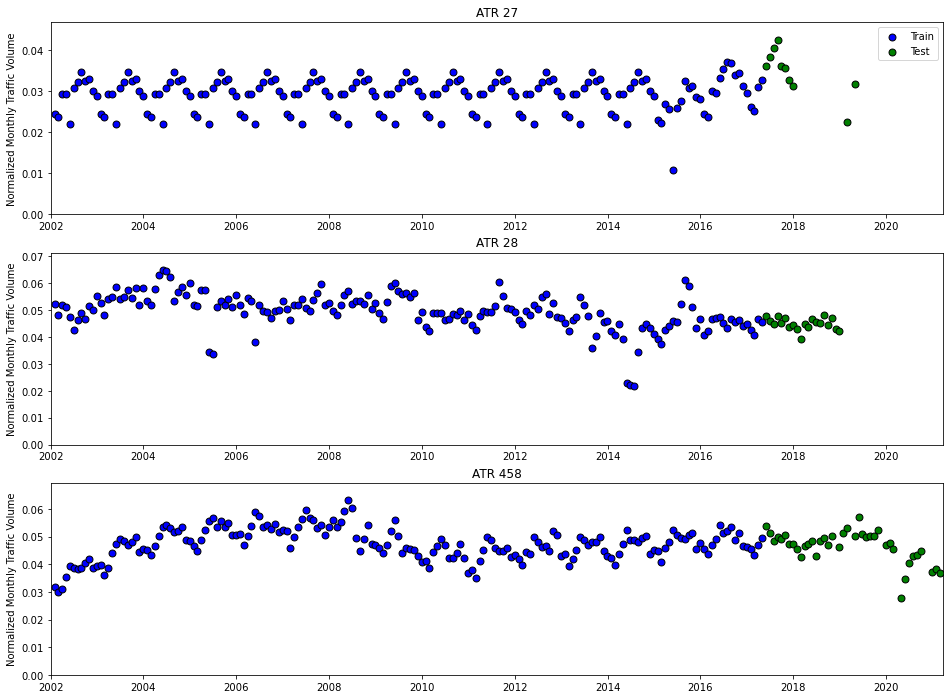

In [181]:
# Chosen to plot series with most entries imputed, series with few imputed, and series with almost none imputed.
plot_cols = ['27', '28', '458']
baseline_1M.plot(plot_cols)

In [182]:
_ = baseline_1M.predict()

station_id,27,28,458
2017-05-31,0.032729,0.045546,0.049389
2017-06-30,0.032729,0.045546,0.049389
2017-07-31,0.032729,0.045546,0.049389
2017-08-31,0.032729,0.045546,0.049389
2017-09-30,0.032729,0.045546,0.049389


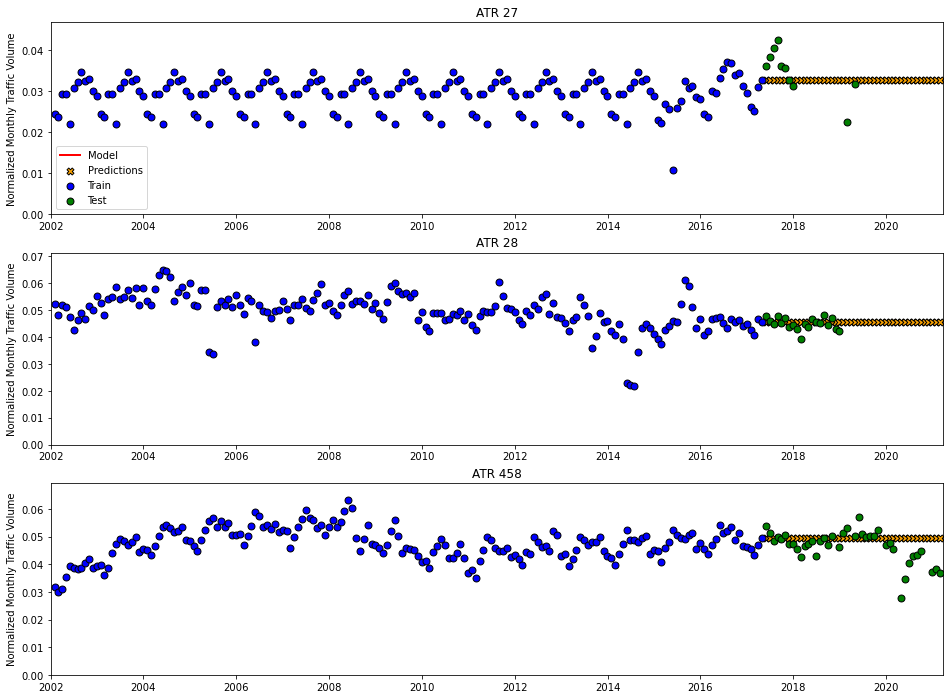

In [183]:
baseline_1M.plot(plot_cols)

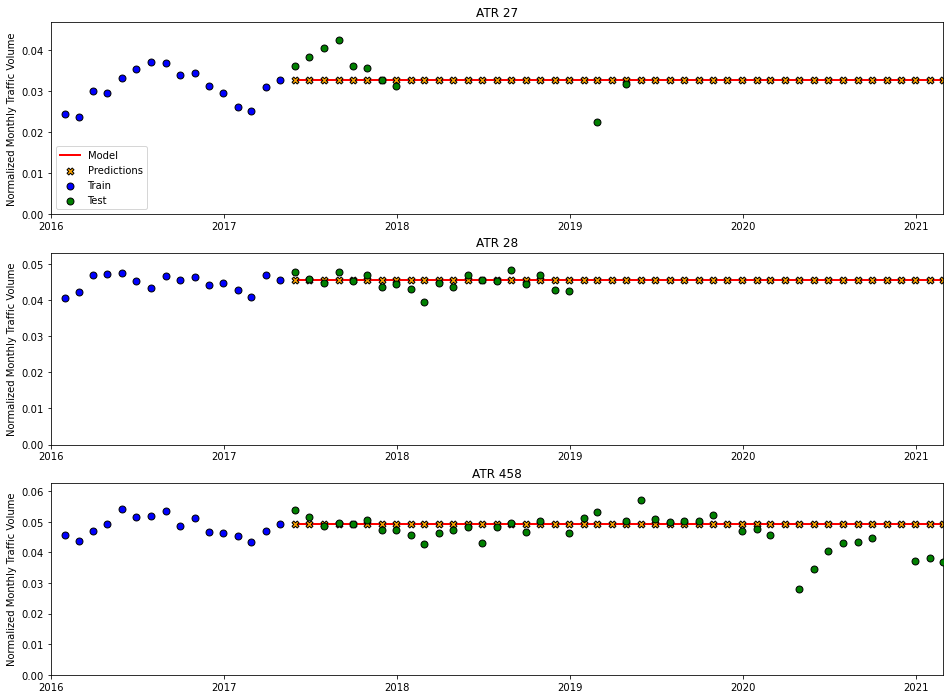

In [184]:
plot_range = dt.date(2016,1,1), dt.date(2021,2,28)
baseline_1M.plot(plot_cols, x_range='custom', date_range=plot_range)

In [185]:
scores = {}
def print_score(m):
    print(f'{m.name}: {scores[m.name]:0.6f}')
def add_score(m):
    scores[m.name] = m.score()
    print_score(m)
add_score(baseline_1M)

baseline_1M: 0.000051


In [186]:
baseline_12M = baseline_model(imputed_df,12)

In [187]:
_ = baseline_12M.predict()

station_id,27,28,458
2017-05-31,0.033338,0.047499,0.054060
2017-06-30,0.035557,0.045251,0.051427
2017-07-31,0.037048,0.043236,0.052053
2017-08-31,0.036807,0.046752,0.053415
2017-09-30,0.034063,0.045510,0.048678
2017-10-31,0.034592,0.046272,0.051277
2017-11-30,0.031385,0.044242,0.046556
2017-12-31,0.029551,0.044831,0.046334
2018-01-31,0.026157,0.042697,0.045464
2018-02-28,0.025264,0.040939,0.043469


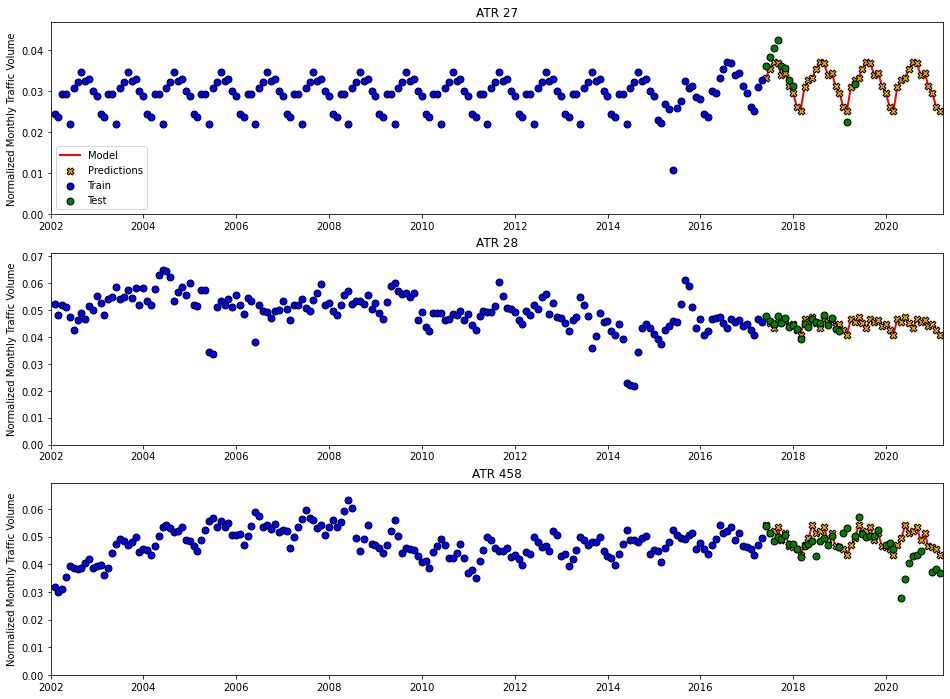

In [188]:
baseline_12M.plot(plot_cols)

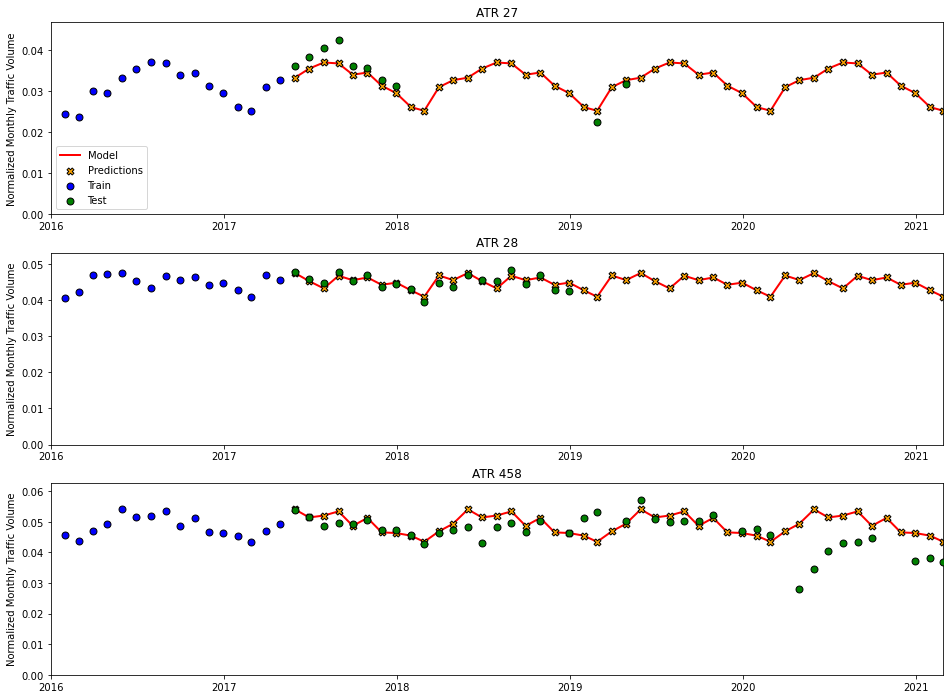

In [189]:
baseline_12M.plot(plot_cols, x_range='custom', date_range=plot_range)

In [190]:
add_score(baseline_12M)

baseline_12M: 0.000022


## Prophet

In [191]:
class prophet_model(model):
    # Default interval size 
    default_interval_width = 0.95
    
    def __init__(self, df):
        model.__init__(self, df)
        
    # Prophet expects a data frame with 2 columns. One column 'ds' with the time stamps and one column 'y' with the data.
    def produce_prophet_series(self, y):
        df = pd.DataFrame({'ds': y.index, 'y':y})
        return df
    
    def _fit_implementation(self, fit_range, **kwargs):
        # There should be one Prophet model trained for every column of the training data frame
        prophet = {}
        
        new_kwargs = {}
        if 'changepoint_prior_scale' in kwargs:  
            new_kwargs['changepoint_prior_scale'] = kwargs['changepoint_prior_scale']
        if 'interval_width' in kwargs:
            new_kwargs['interval_width'] = kwargs['interval_width']
        else:
            new_kwargs['interval_width'] = self.default_interval_width
        if 'mcmc_samples' in kwargs:
            new_kwargs['mcmc_samples'] = kwargs['mcmc_samples']
            
        if fit_range == 'validation_train':
            df = self._data.validation_train
        elif fit_range == 'train':
            df = self._data.train
        else:
            df = self._data.full
            
        for col in df:
            y = self.produce_prophet_series(df[col])
            mod = Prophet(daily_seasonality=False, weekly_seasonality=False, **new_kwargs)
            mod.fit(y)
            prophet[col] = mod
        
        return prophet
    
    @staticmethod
    def _implements_validation():
        return True
    
    # Only needs to be implemented if _implements_validation returns True.
    def _validation_implementation(self, fit_range, validation_range, **kwargs):
        # Individual model validation implementation
        # TODO: Not implemented yet!!!
        raise NotImplementedError
    
    # Must be implemented
    def _predict_implementation(self, date_index, margin_of_error=False):
        predictions = {}
        if margin_of_error:
            predictions_upper = {}
            predictions_lower = {}
        
        # To make predictions, the Prophet model requires the number of time periods to project into the future
        if self._fit_range == 'validation_train':
            df = self._data.validation
        elif self._fit_range == 'train':
            df = self._data.train
        else:
            df = self._data.full

        full_idx = df.index.union(date_index)
        future_periods = len(date_index.difference(df.index))
        prediction_length = len(date_index)
        
        for col in df:
            mod = self._model[col]
            # FUTURE: Frequency hard coded
            prediction_frame = mod.make_future_dataframe(periods=future_periods, freq='M')

            model_prediction = mod.predict(prediction_frame)
            yhat = model_prediction['yhat'][-prediction_length:]
            yhat.index = date_index
            yhat[yhat < 0] = 0
            predictions[col] = yhat
               
            if margin_of_error:
                yhat_upper = model_prediction['yhat_upper'][-prediction_length:]
                yhat_upper.index = date_index
                yhat_upper[yhat_upper < 0] = 0
                predictions_upper[col] = yhat_upper
                
                yhat_lower = model_prediction['yhat_lower'][-prediction_length:]
                yhat_lower.index = date_index
                yhat_lower[yhat_lower < 0] = 0
                predictions_lower[col] = yhat_lower
        
        prediction = pd.DataFrame(predictions)
        
        if margin_of_error:
            prediction_lower = pd.DataFrame(predictions_lower)
            prediction_upper = pd.DataFrame(predictions_upper)
            return prediction, prediction_lower, prediction_upper
        else:
            return prediction
        
    @staticmethod
    def _implements_margin_of_error():
        return True

In [192]:
prophet = prophet_model(imputed_df)

In [193]:
%%time
prophet.fit('train')

Wall time: 307 ms


In [194]:
%%time
_ = prophet.predict(margin_of_error=True);

Wall time: 4.19 s


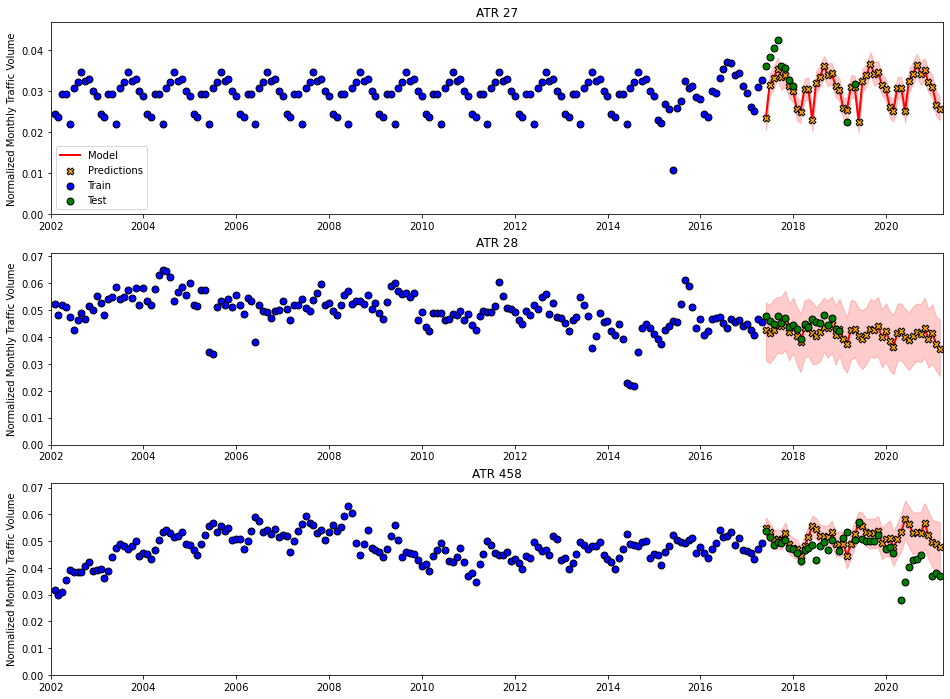

In [195]:
prophet.plot(plot_cols)

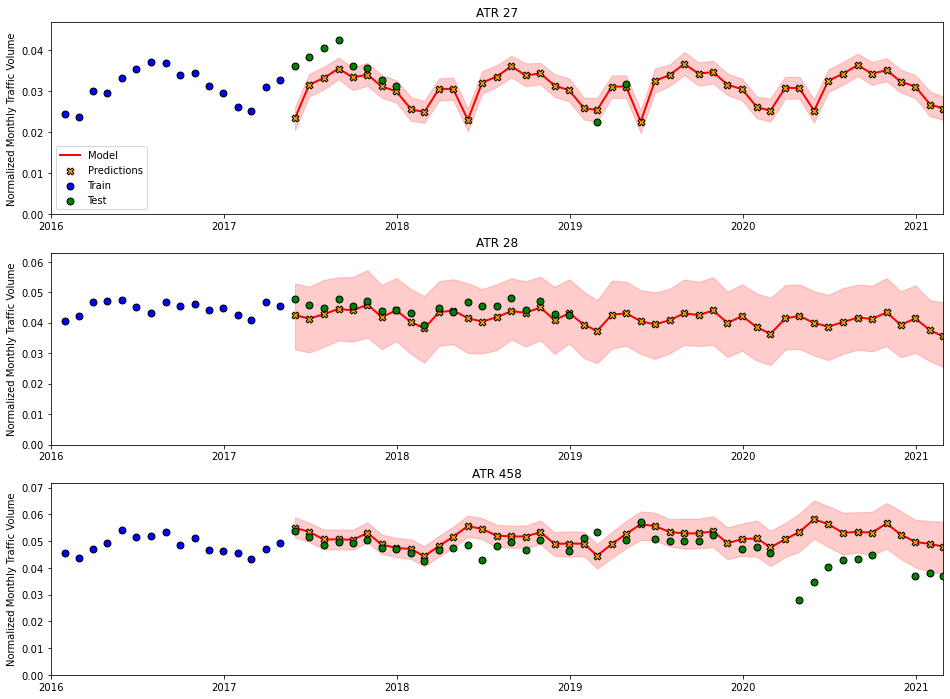

In [196]:
prophet.plot(plot_cols, x_range='custom', date_range=plot_range)

In [197]:
add_score(prophet)

prophet_model: 0.000062


## SARIMA

Use auto-arima to determine best parameters.

In [962]:
def fit_arima(train_df, information_criterion='aic', scoring='mse', out_of_sample_size=None):
    '''
    information_criterion can be any of 'aic', 'bic', or 'hqic'. Ignored if out_of_sample_size is not None
    scoring can be either of 'mse', 'mae'. Ignored if out_of_sample_size is None.
    '''
    df = train_df.copy()
    
    # Evaluate val_holdout
    # If None, nothing is heldout.
    # If a positive integer, that many entries are heldout.
    # If a float between 0 and 1, that proportion of entries are heldout.
    # All other cases, val_holdout holds nothing out.
    if out_of_sample_size is not None:
        if isinstance(out_of_sample_size, int):
            if out_of_sample_size <= 0:
                out_of_sample_size = 0
        elif isinstance(out_of_sample_size, float):
            if out_of_sample_size > 0 and out_of_sample_size < 1:
                out_of_sample_size = int(len(train_df) * out_of_sample_size)
            else:
                out_of_sample_size = None
        else:
            out_of_sample_size = None

    arima_parameters = {}
    for col in df:
        y = df[col]
        if out_of_sample_size is None:
            auto = pmdarima.arima.auto_arima(y, seasonal=True, m=12, information_criterion=information_criterion)
        else:
            auto = pmdarima.arima.auto_arima(y, seasonal=True, m=12, scoring=scoring, 
                                             out_of_sample_size=out_of_sample_size)
            
        col_parameters = {
            'order': auto.order,
            'seasonal_order': auto.seasonal_order,
            'with_intercept': auto.with_intercept
        }
        
        arima_parameters[col] = col_parameters
        
    return arima_parameters

In [ ]:
class sarima_model(model):
    
    def __init__(self, df):
        model.__init__(self, df)

    # This is still Prophet implementation...
    
    def _fit_implementation(self, fit_range, **kwargs):
        # There should be one Prophet model trained for every column of the training data frame
        prophet = {}
        
        new_kwargs = {}
        if 'changepoint_prior_scale' in kwargs:  
            new_kwargs['changepoint_prior_scale'] = kwargs['changepoint_prior_scale']
        if 'interval_width' in kwargs:
            new_kwargs['interval_width'] = kwargs['interval_width']
        else:
            new_kwargs['interval_width'] = self.default_interval_width
        if 'mcmc_samples' in kwargs:
            new_kwargs['mcmc_samples'] = kwargs['mcmc_samples']
            
        if fit_range == 'validation_train':
            df = self._data.validation_train
        elif fit_range == 'train':
            df = self._data.train
        else:
            df = self._data.full
            
        for col in df:
            y = self.produce_prophet_series(df[col])
            mod = Prophet(daily_seasonality=False, weekly_seasonality=False, **new_kwargs)
            mod.fit(y)
            prophet[col] = mod
        
        return prophet
    
    @staticmethod
    def _implements_validation():
        return True
    
    # Only needs to be implemented if _implements_validation returns True.
    def _validation_implementation(self, fit_range, validation_range, **kwargs):
        # Individual model validation implementation
        # TODO: Not implemented yet!!!
        raise NotImplementedError
    
    # Must be implemented
    def _predict_implementation(self, date_index, margin_of_error=False):
        predictions = {}
        if margin_of_error:
            predictions_upper = {}
            predictions_lower = {}
        
        # To make predictions, the Prophet model requires the number of time periods to project into the future
        if self._fit_range == 'validation_train':
            df = self._data.validation
        elif self._fit_range == 'train':
            df = self._data.train
        else:
            df = self._data.full

        full_idx = df.index.union(date_index)
        future_periods = len(date_index.difference(df.index))
        prediction_length = len(date_index)
        
        for col in df:
            mod = self._model[col]
            # FUTURE: Frequency hard coded
            prediction_frame = mod.make_future_dataframe(periods=future_periods, freq='M')

            model_prediction = mod.predict(prediction_frame)
            yhat = model_prediction['yhat'][-prediction_length:]
            yhat.index = date_index
            yhat[yhat < 0] = 0
            predictions[col] = yhat
               
            if margin_of_error:
                yhat_upper = model_prediction['yhat_upper'][-prediction_length:]
                yhat_upper.index = date_index
                yhat_upper[yhat_upper < 0] = 0
                predictions_upper[col] = yhat_upper
                
                yhat_lower = model_prediction['yhat_lower'][-prediction_length:]
                yhat_lower.index = date_index
                yhat_lower[yhat_lower < 0] = 0
                predictions_lower[col] = yhat_lower
        
        prediction = pd.DataFrame(predictions)
        
        if margin_of_error:
            prediction_lower = pd.DataFrame(predictions_lower)
            prediction_upper = pd.DataFrame(predictions_upper)
            return prediction, prediction_lower, prediction_upper
        else:
            return prediction
        
    @staticmethod
    def _implements_margin_of_error():
        return True

In [964]:
%%time
arima_aic = fit_arima(imputed_train_df)

C:\Users\wodar\anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1897: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
C:\Users\wodar\anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1897: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
C:\Users\wodar\anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1897: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
C:\Users\wodar\anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1897: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
C:\Users\wodar\anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1897: RuntimeWarning: divide by zero encoun

Wall time: 1h 12min 38s


In [965]:
%%time
arima_mse = fit_arima(imputed_train_df, out_of_sample_size=0.1)

C:\Users\wodar\anaconda3\envs\tensorflow-gpu\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,0,2)(2,0,2)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\wodar\anaconda3\envs\tensorflow-gpu\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\wodar\anaconda3\envs\tensorflow-gpu\lib\site-packages\pmdarima\arima\arima.py", line 482, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\wodar\anaconda3\envs\tensorflow-gpu\lib\site-packages\pmdarima\arima\arima.py", line 403, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\wodar\anaconda3\envs\tensorflow-gpu\lib\site-packages\pmdarima\arima\arima.py", line 393, in _fit_wrapper
    return arima, arima.fit(start_params=start_params,
  File "C:\Users\wodar\anaconda3\envs\tensorflow-gpu\lib\s

Wall time: 1h 34min 59s


In [ ]:
class sarima_model(model):
    def __init__(self):
        self._models = None
    
    def fit(self, train_df):
        self._models = {}
        
        for col in train_df:
            y = train_df[col]
            auto = pmdarima.arima.auto_arima(y, seasonal=True, m=12)
            order = auto.order
            seasonal_order = auto.seasonal_order
            
            model = Prophet(daily_seasonality=False, weekly_seasonality=False, 
                            changepoint_prior_scale=changepoint_prior_scale)
            model.fit(y)
            self._models[col] = model
            
    def predict(self, test_df):
        # test_df should have the same columns as train_df
        # Returns a data frame with same columns as train_df and same index as test_df
        predictions = {}
        
        for col in test_df:
            model = self._models[col]
            # FUTURE: allow frequency to change.
            future = model.make_future_dataframe(periods=len(test_df), freq='M')
            forecast = model.predict(future)
            start_idx = len(future) - len(test_df)
            yhat = forecast['yhat'][start_idx:]
            yhat.index = test_df.index
            predictions[col] = yhat   
        
        prediction = pd.DataFrame(predictions)
        self._prediction = prediction
        return prediction

In [76]:
pmd = pmdarima.arima.auto_arima(imputed_train_df['26'], seasonal=True, m=12)

In [81]:
pmd.order

(0, 1, 1)

In [82]:
pmd.seasonal_order

(1, 1, 2, 12)

In [77]:
dir(pmd)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_exog',
 '_check_n_features',
 '_fit',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 '_warn_for_older_version',
 'aic',
 'aicc',
 'arima_res_',
 'arparams',
 'arroots',
 'bic',
 'bse',
 'conf_int',
 'df_model',
 'df_resid',
 'fit',
 'fit_predict',
 'fit_with_exog_',
 'get_params',
 'hqic',
 'maparams',
 'maroots',
 'maxiter',
 'method',
 'nobs_',
 'oob',
 'oob_',
 'oob_preds_',
 'order',
 'out_of_sample_size',
 'params',
 'pkg_version_',
 'plot_diagnostics',
 'pr

In [1004]:
%%time
pmdarima.arima.auto_arima(imputed_train_df['27'], seasonal=True, m=12)

Wall time: 26.3 s


ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(2, 0, 2, 12),
      suppress_warnings=True)

In [1005]:
%%time
pmdarima.arima.auto_arima(imputed_train_df['28'], seasonal=True, m=12, out_of_sample_size=int(0.1*len(imputed_train_df['28'])))

Wall time: 49.7 s


ARIMA(order=(1, 1, 2), out_of_sample_size=18, scoring_args={},
      seasonal_order=(0, 0, 1, 12), suppress_warnings=True,
      with_intercept=False)

In [1006]:
%%time
pmdarima.arima.auto_arima(imputed_train_df['28'], seasonal=True, m=12)

Wall time: 34.3 s


ARIMA(order=(2, 1, 3), scoring_args={}, seasonal_order=(1, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [86]:
pmd.predict(len(test_df['26']))

array([0.12375344, 0.13074139, 0.13992916, 0.1367599 , 0.11969821,
       0.11833852, 0.11173771, 0.10735528, 0.09305092, 0.08761999,
       0.11260122, 0.11127569, 0.12468391, 0.13154886, 0.14014862,
       0.13718565, 0.11997108, 0.11934448, 0.11297153, 0.10931666,
       0.0948441 , 0.08953668, 0.11424249, 0.11301075, 0.12671322,
       0.13361076, 0.14236631, 0.13934869, 0.12217462, 0.1213538 ,
       0.11492048, 0.11107284, 0.09664485, 0.0913047 , 0.11608348,
       0.11482689, 0.12845141, 0.13534031, 0.14405458, 0.14105144,
       0.12386664, 0.12309728, 0.11667995, 0.11288339, 0.09844359,
       0.09311211])

In [1003]:
pmd.predict(len(test_df['26']))

array([0.12375344, 0.13074139, 0.13992916, 0.1367599 , 0.11969821,
       0.11833852, 0.11173771, 0.10735528, 0.09305092, 0.08761999,
       0.11260122, 0.11127569, 0.12468391, 0.13154886, 0.14014862,
       0.13718565, 0.11997108, 0.11934448, 0.11297153, 0.10931666,
       0.0948441 , 0.08953668, 0.11424249, 0.11301075, 0.12671322,
       0.13361076, 0.14236631, 0.13934869, 0.12217462, 0.1213538 ,
       0.11492048, 0.11107284, 0.09664485, 0.0913047 , 0.11608348,
       0.11482689, 0.12845141, 0.13534031, 0.14405458, 0.14105144,
       0.12386664, 0.12309728, 0.11667995, 0.11288339, 0.09844359,
       0.09311211])